## Dataset Tools - OSM to GeoJSON + Visualizer
This notebook is used to convert OSM data to GeoJSON. Only the geometry related data along with type of the geometries is preserved.

Unnecessary/unrelated data in the OSM set is removed during conversion. The notebook also contains interactive visualization of the data.

In [1]:
#%pip install osmnx
#%pip install folium
#%pip install tqdm
#%pip install jsonlines
import jsonlines
import glob
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import tqdm
import shapely
import random
import os
from shapely.wkt import loads
import re
import seaborn as sns

Documentation for osmnx (used for downloading the data): https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries 

OSM data model explained (nodes, ways, relations): https://labs.mapbox.com/mapping/osm-data-model/

Plotting polygons with Folium: https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html 

List of possible tags: https://wiki.openstreetmap.org/wiki/Map_features

#### Downloads geometry data from OSM and stores in variable.
Specify a coordinate and radius, and the program will do the rest.

In [2]:
RADIUS, GEOCODE, LOCAL = 0,1,2
tags = []

TYPE = LOCAL
origin = (55.70293, 13.19914) # coordinates for origin, now Lund
dist = 2 * 10000 # distance in m (mil left part)
zoom_start = 14

if TYPE == RADIUS:
    tags = ['building', 'highway'] # Specify the types to get, see above link for possible tags
    dist = 2000
    #tags = ['boundary']
    df = ox.geometries.geometries_from_point(origin, {x: True for x in tags}, dist=dist)
    #tags = {'boundary': ['place']}
    #df = ox.geometries.geometries_from_point(origin, tags, dist=dist)

elif TYPE == GEOCODE:
    df = ox.geocode_to_gdf('USA')

elif TYPE == LOCAL:
    zoom_start = 3
    SINGLE_SHP_FILE = True
    if SINGLE_SHP_FILE:
        df = gpd.read_file('data/ne_10m_admin_1_states_provinces.shp')
        print(df)
    else:
        df = gpd.GeoDataFrame()
        shp_base_loc = 'data/sweden-latest-free'
        files = glob.glob(shp_base_loc + '/*.shp')
        for i in tqdm.tqdm(range(len(files))):
            f = files[i]
            print(i + 1, ':', f)
            to_append = gpd.read_file(f)
            print(i + 1, 'contains', len(to_append), 'geometries')
            df = gpd.pd.concat([df, to_append], copy=False)

# Filter to only keep polygons, i.e. skip ex. LineString, Point
#df = df[df.type == "Polygon"]

# Remove Points, i.e. keep only geometries
df = df[df.type != "Point"]
print("Count of entries:", len(df))

                                               geometry
0     POLYGON ((-58.20011 -32.44713, -58.20012 -32.4...
1     POLYGON ((-58.20012 -32.44720, -58.20011 -32.4...
2     MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...
3     MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...
4     POLYGON ((-69.51009 -17.50659, -69.50611 -17.5...
...                                                 ...
4591  POLYGON ((14.51073 35.88896, 14.51537 35.89113...
4592  POLYGON ((14.52937 35.88156, 14.52700 35.87772...
4593  POLYGON ((14.49801 35.89251, 14.49616 35.88830...
4594  POLYGON ((14.48663 35.88636, 14.48231 35.88979...
4595  POLYGON ((14.52126 35.88711, 14.51537 35.89113...

[4596 rows x 1 columns]
Count of entries: 4596


In [3]:
# Preview filtered data
# df.geometry.plot(figsize=(6, 6))
# plt.axis('off')
# plt.show()

In [4]:
# Folium wants coordinate system: EPSG:4326. OK!
df.crs

#### Export to GeoJSON
Below, the tag (type) of each polygon is found, irrelevant data is removed, and the final data-frame is serialized and saved as GeoJSON.

The export location is "data/latest_export.json".

In [5]:
# Construct type column
df_stripped = []
for i in tqdm.tqdm(range(len(df))):
    r = df.iloc[i]
    found_tag = None
    for tag in tags:
        if str(r[tag]) != 'nan':
            #if found_tag != None: raise Exception("Ambiguity found!")
            found_tag = tag
    df_stripped.append({'type': found_tag, 'geometry': r.geometry})

df_stripped = gpd.GeoDataFrame(df_stripped)

ONE_FILE = True
MAX_ENTRIES_FILE = 100000
NUM_DECIMALS = 7 # -1 for no change

if NUM_DECIMALS != -1:
    simple_dec = re.compile(r"\d*\.\d+")
    def m_round(match):
        return ("{:." + str(NUM_DECIMALS) + "f}").format(float(match.group()))
    df_stripped.geometry = df_stripped.geometry.apply(lambda x: loads(re.sub(simple_dec, m_round, x.wkt)))

if ONE_FILE:
    # Avoid to large files -> sample data
    if len(df_stripped) > MAX_ENTRIES_FILE:
        keep_idxs = [random.randint(0, len(df_stripped) - 1) for i in range(MAX_ENTRIES_FILE)]
        df_stripped = df_stripped.loc[keep_idxs]
    df_stripped.to_file(filename='data/latest_export.json', driver='GeoJSON')
else:
    OUT_FOLDER = 'data/latest_export'
    if not os.path.exists(OUT_FOLDER):
        os.makedirs(OUT_FOLDER)
    for f in glob.glob(OUT_FOLDER + '/*'):
        os.remove(f)
    for i in tqdm.tqdm(range(len(df_stripped))):
        r = df_stripped.iloc[i]
        geo = gpd.GeoSeries(r['geometry']) # Parse Geometry for row to generate JSON
        geo = gpd.GeoDataFrame({'type': r['type'], 'geometry': geo}) # Type is needed for coloring
        geo_json = geo.to_json() #[43:-2] # Remove FeatureCollection part
        # Write to disk
        f = open(f"{OUT_FOLDER}/{i}.json", "w")
        f.write(geo_json)
        f.close()

100%|██████████| 4596/4596 [00:00<00:00, 15430.63it/s]


#### Visualizer
Below, an interactive map of the polygons is generated. The different types are represented by different fill colors.

By setting SHOW_TILES to True, the OSM is rendered in the background. Setting it to False allows for a more obvious visualization of the polygons.

In [6]:
DO_VISUALIZATION = False
SHOW_TILES = False

if DO_VISUALIZATION:
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    tag_colors = {x: colors[idx % len(colors)] for idx, x in enumerate(tags)}

    map = folium.Map(location=[origin[0], origin[1]], zoom_start=zoom_start, tiles='CartoDB positron' if SHOW_TILES else None)

    for _, r in df_stripped.iterrows():
        geo = gpd.GeoSeries(r['geometry']) # Parse Geometry for row to generate JSON
        geo = gpd.GeoDataFrame({'type': r['type'], 'geometry': geo}) # Type is needed for coloring
        geo_json = geo.to_json()
        geo_json = folium.GeoJson(data=geo_json,
                            style_function=lambda x: {
                                    'weight': '1',
                                    'fillOpacity': '0.7',
                                    'fillColor': tag_colors[x['properties']['type']] if x['properties']['type'] != None else 'blue'
                                })
        geo_json.add_to(map)
if SHOW_TILES:
    display(map)

#### Statistics of dataset

In [7]:
IMPORT_INTERSECTION_DATA = False
EXPORT_INTERSECTION_DATA = False
INCL_INTERSECTION_DATA = False

op_df = df_stripped.copy()
#display(op_df)

In [8]:
def nbr_verticies(geometry):
    return  shapely.count_coordinates(geometry)

def geo_length(geometry):
    return  shapely.length(geometry)

def geo_area(geometry):
 return shapely.area(geometry)

def geo_type(geometry):
    return geometry.geom_type

def count_intersections(geometry):
    geo1_total = 0
    for geo2 in df_stripped['geometry']:
        if not shapely.equals_exact(geometry, geo2):
            if shapely.intersects(geometry, geo2):
                geo1_total += 1
    return geo1_total

In [9]:
if IMPORT_INTERSECTION_DATA:
    op_df = pd.read_csv('./intersection_df')
    op_df['geometry'] = op_df['geometry'].apply(lambda x: shapely.wkt.loads(x))
    
if INCL_INTERSECTION_DATA and not IMPORT_INTERSECTION_DATA:
    op_df["intersection"] = op_df['geometry'].apply(lambda x: count_intersections(x))

if EXPORT_INTERSECTION_DATA:
    op_df.to_csv('./intersection_df')
    
op_df["area"] = op_df['geometry'].apply(lambda x: geo_area(x))
op_df["length"] = op_df['geometry'].apply(lambda x: geo_length(x))
op_df["verticies"] = op_df['geometry'].apply(lambda x: nbr_verticies(x))
op_df["type"] = op_df['geometry'].apply(lambda x: geo_type(x))
op_df["convex_hull"] = op_df['geometry'].apply(lambda x: shapely.count_coordinates(shapely.convex_hull(x)))

In [10]:
df_vert = op_df['verticies']
v_cnt = {i + 1: 0 for i in range(max(df_vert))}
for r in df_vert:
    v_cnt[r] += r
for i in range(max(df_vert)):
    if v_cnt[i+1] == 0:
        del v_cnt[i+1]
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
v_cnt = pd.DataFrame.from_dict(v_cnt, orient='index', columns=['weightedSum'])
v_cnt['count'] = v_cnt.apply(lambda x:x.weightedSum/ x.name, axis=1)
import seaborn as sns
ax = sns.barplot(x=v_cnt.index, y=v_cnt['count'],color='b')
ax.bar_label(ax.containers[0],label_type='edge')
sns.barplot(x=v_cnt.index, y=v_cnt.weightedSum,orient='v')
plt.xlabel("Vertex count")
plt.ylabel("Weighted occurances")
plt.title("Vertex Distribution")
plt.show()

plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
ax = sns.barplot(x=v_cnt.index, y=v_cnt['count'])
plt.xlabel("Vertex count")
plt.ylabel("Occurances")
plt.title("")
plt.show()

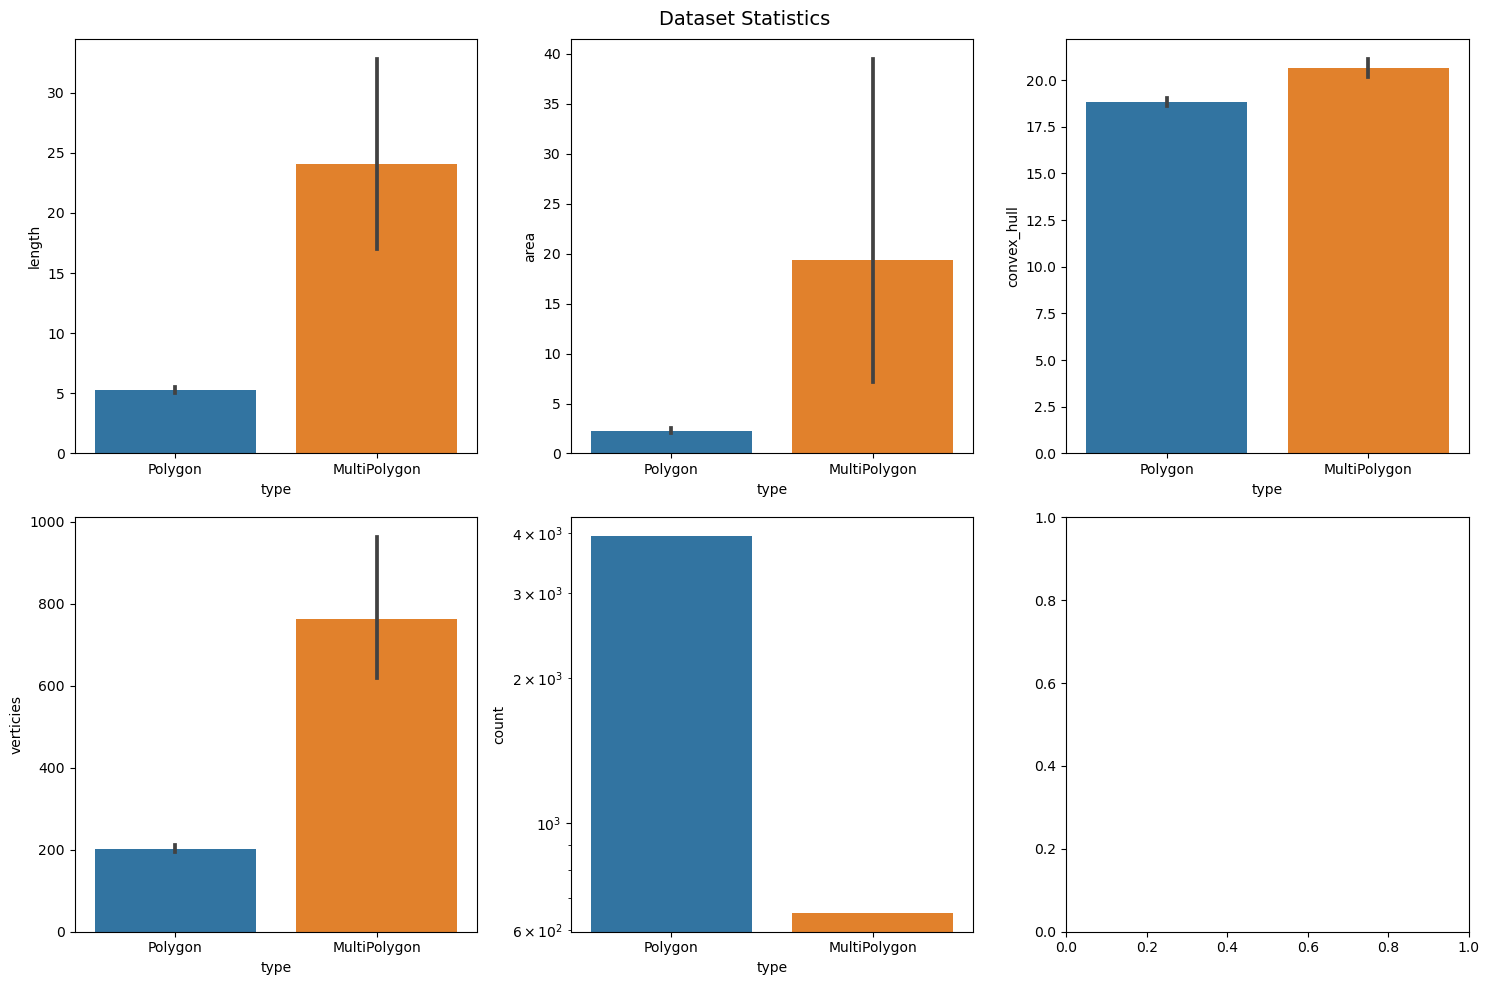

In [ ]:
figure, axis = plt.subplots(2, 3)
figure.set_figwidth(15)
figure.set_figheight(10)
figure.suptitle("Dataset Statistics", fontsize=14)

sns.barplot(data=op_df, x='type', y='area',ax=axis[0,1])
sns.barplot(data=op_df, x='type', y='length',ax=axis[0,0])
sns.barplot(data=op_df, x='type', y='verticies',ax=axis[1,0])
sns.barplot(data=op_df, x='type', y='convex_hull',ax=axis[0,2])

if INCL_INTERSECTION_DATA:
    sns.barplot(data=op_df, x='type', y='intersection',ax=axis[1,2])
    
g = sns.countplot(x=op_df["type"],ax=axis[1,1])
g.set_yscale("log")
plt.tight_layout()
plt.show()